In [8]:
# Data Processing
import pandas as pd
import numpy as np

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image

######################################
from matplotlib import pyplot as plt

In [9]:
#df = pd.read_csv("compas-scores-two-years-violent.csv", index_col=0)
df = pd.read_csv("compas-scores-two-years.csv", index_col=0)


In [10]:
y = y = df['two_year_recid']
keep_cols = [
    'age',             # defendant age
    'sex',             # male/female
    'race',            # categorical
    'priors_count',    # number of prior offenses
    'c_charge_degree'  # felony vs misdemeanor
]

X_safe = df[keep_cols].copy()

# One‐hot encode the categoricals
X= pd.get_dummies(X_safe, drop_first=True)

#  Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Classifier
rf = RandomForestClassifier(random_state=42)

rf.fit(X_train, y_train)

#  Make predictions
y_pred = rf.predict(X_test)

Accuracy: 0.64
Precision: 0.58
Recall: 0.58


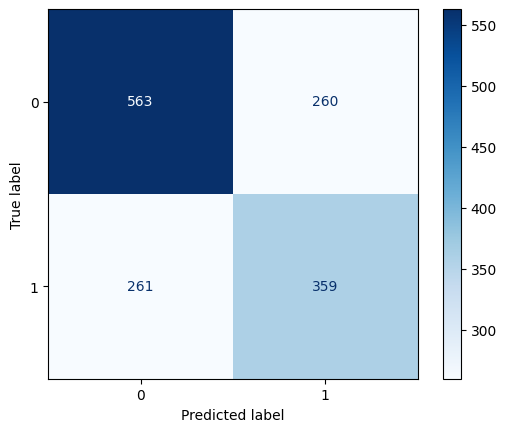

In [11]:
#  Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
disp = ConfusionMatrixDisplay(confusion, display_labels=rf.classes_)
disp.plot(cmap='Blues')
plt.show()